In [ ]:
import os
import shutil
import scipy
from scipy import stats
from skimage.io import imread, imsave
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [ ]:
imgdir='/data/Devel_Human/Images'
maskdir='/data/Devel_Human/GTmasks'

# Utility Functions

In [ ]:
from skimage.segmentation import (
    watershed, relabel_sequential,
    find_boundaries
)
from skimage import measure
import scipy
from skimage.feature import peak_local_max

from skimage.segmentation import (
    watershed, relabel_sequential,
    find_boundaries
)
from skimage import measure
import scipy
from skimage.feature import peak_local_max

def label_watershed(fgmask):

    distance = scipy.ndimage.distance_transform_edt(fgmask)
    coords = peak_local_max(distance, min_distance=4, footprint=np.ones((5, 5)))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = scipy.ndimage.label(mask)
    return watershed(-distance, markers, mask=fgmask)

In [ ]:
def show_images_side_by_side(img_id,image1, image2,background_img):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(image1)
    axes[0].imshow(background_img,alpha=0.5)
    axes[0].axis('off')

    axes[1].imshow(image2)
    axes[1].imshow(background_img,alpha=0.5)
    axes[1].axis('off')

    plt.tight_layout()
    plt.title(img_id)
    plt.show()

def combine_out_array(out):
    if out.shape[-1]>0:
        out_combined = out[...,0].astype(np.uint16)
        for x in range(1,out.shape[-1]):
            out_combined += out[...,x].astype(np.uint16)*(x+1)
        return out_combined
    else: return np.zeros(out.shape[:-1],out.dtype)

In [ ]:
def display_annotated_cells(original_image, annotated_cells,image_id,save=False):
    # Create a copy of the original image
    import cv2
    display_image = original_image.copy()

    # Iterate over each annotated cell
    for i in range(annotated_cells.shape[2]):
        # Extract the binary annotation for the current cell
        cell_annotation = annotated_cells[:, :, i]

        # Create a boolean mask for the current cell annotation
        cell_mask = np.zeros_like(original_image[:, :, 0])
        cell_mask[cell_annotation > 0] = 255

        # Convert the mask to BGR color space
        cell_mask_bgr = cv2.cvtColor(cell_mask, cv2.COLOR_GRAY2BGR)

        # Set the red channel to maximum intensity (255)
        cell_mask_bgr[:, :, 0][cell_mask == 255] = 255
        cell_mask_bgr[:, :, 1][cell_mask == 255] = 0
        cell_mask_bgr[:, :, 2][cell_mask == 255] = 0
        # Add the cell mask to the display image
        display_image = cv2.add(display_image, cell_mask_bgr)

    plt.figure(figsize=(10, 10))
    plt.subplot(1,2,1)
    plt.title(image_id)
    plt.axis('off')
    plt.imshow(original_image)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(display_image)
    plt.title(image_id)
    plt.axis('off')
    if save:
        output_filename = os.path.join(img_out_dir, image_id + '.jpg')
        plt.savefig(output_filename, format='jpg', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

#Small Section Load Mask Sample (Previous Training)

In [ ]:
import skimage.io
big_o=[]
cell_masks = []

m = skimage.io.imread(os.path.join(maskdir, "%s.tif"%str('15338')),plugin='pil').astype(np.uint8)[300:400,300:400]
msk_lbl = measure.label(m==255)
props = measure.regionprops_table(msk_lbl,m,properties=('label','area','bbox_area'))
big_o = props['label'][np.where(props['area']>150)]
small_o = props['label'][np.where(props['area']<10)]


for jj in range(1,msk_lbl.max()+1):
    if jj not in small_o:
        if jj not in big_o:
            cell_masks.append(msk_lbl==jj)
            pass

        else:
    #         split
            newlbl = label_watershed(msk_lbl==jj)
            for ll in range(1,newlbl.max()+1):
                props = measure.regionprops_table((newlbl==ll)*1,newlbl,properties=('label','area','bbox_area'))
                if props['area']<16:
                    pass
                else:
                    cell_masks.append(newlbl==ll)

mask = np.dstack(cell_masks)

# return mask, np.ones([mask.shape[-1]], dtype=np.int32)

In [ ]:
mask.shape

(100, 100, 52)

In [ ]:
orig_img=skimage.io.imread(os.path.join(imgdir, "%s.jpg"%str('15338'))).astype(np.uint8)

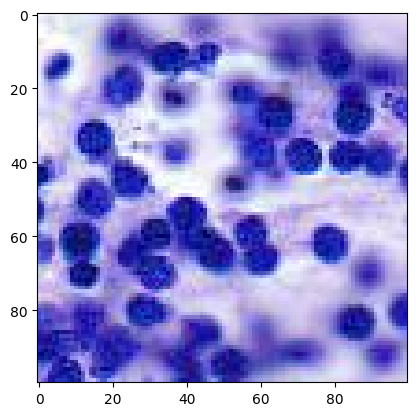

In [ ]:
plt.imshow(orig_img[300:400,300:400,:])

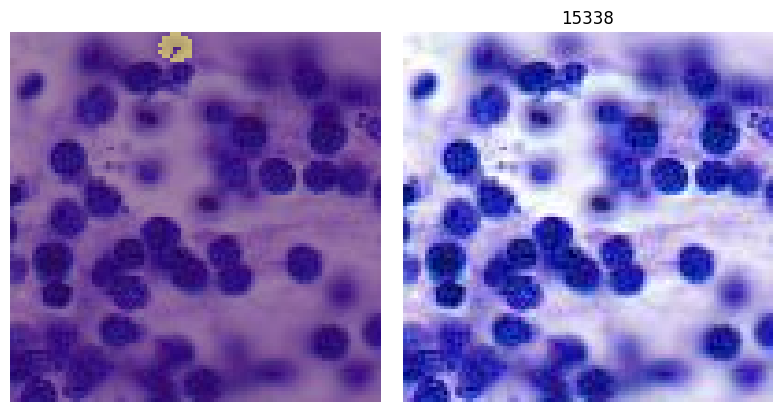

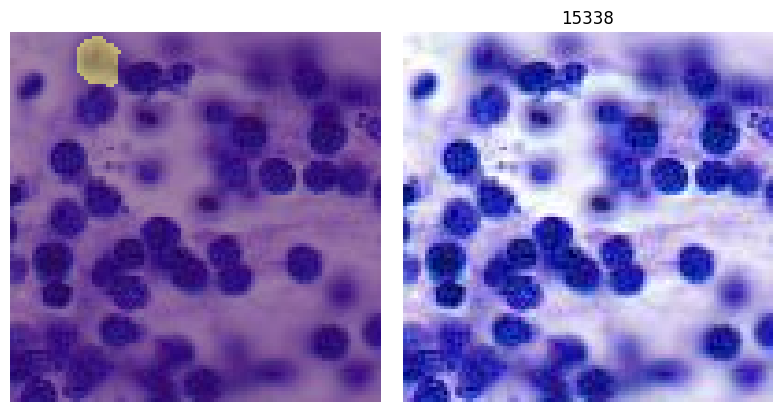

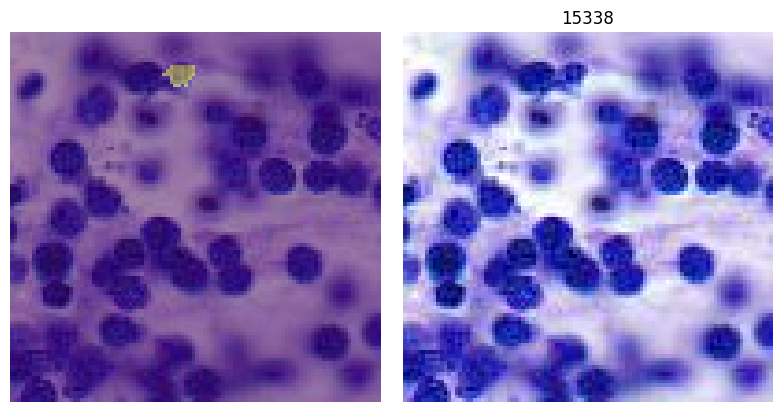

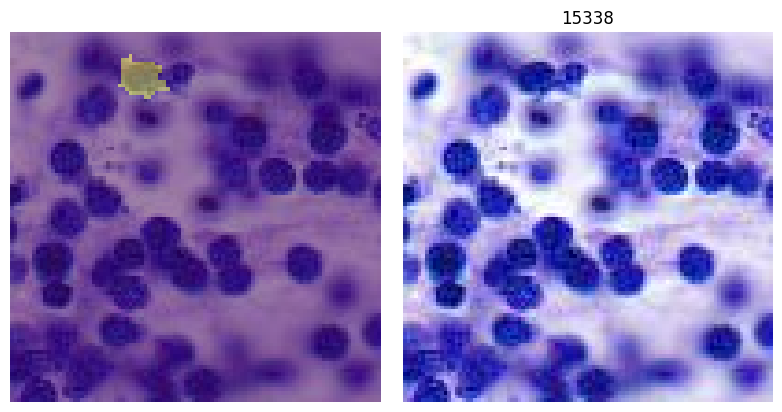

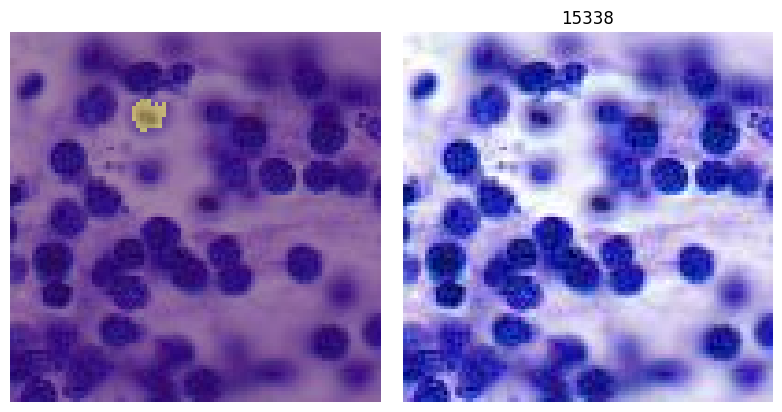

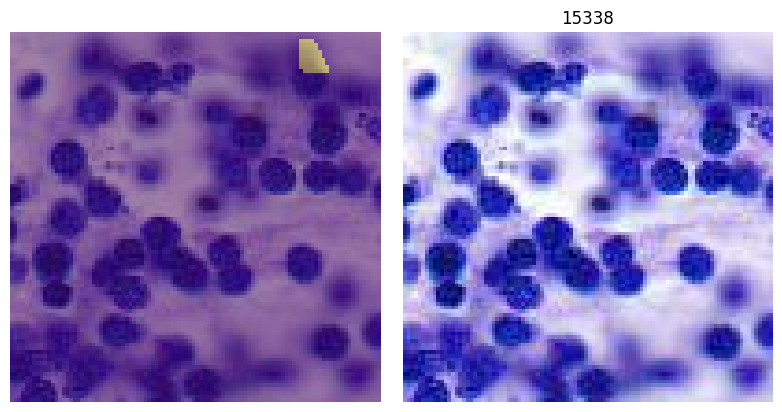

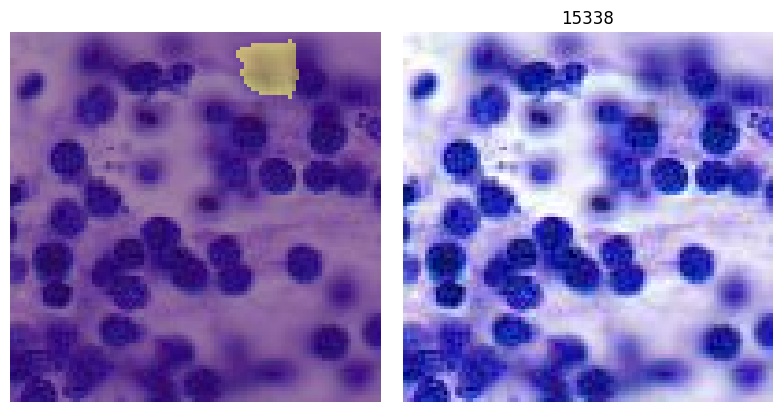

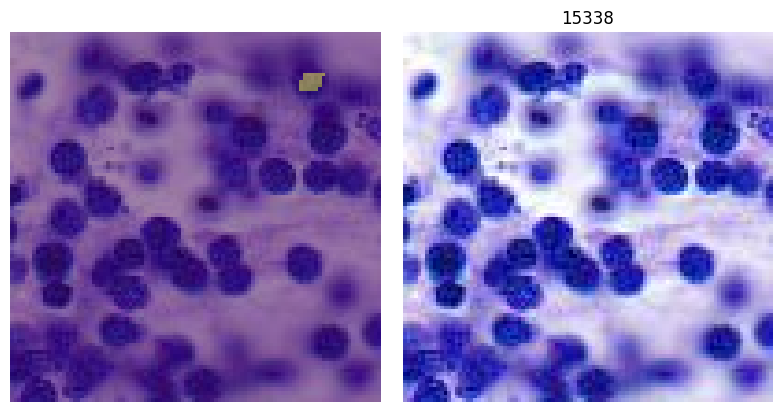

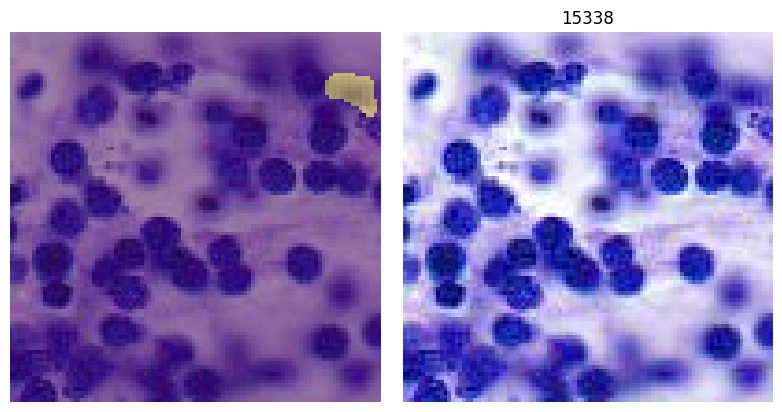

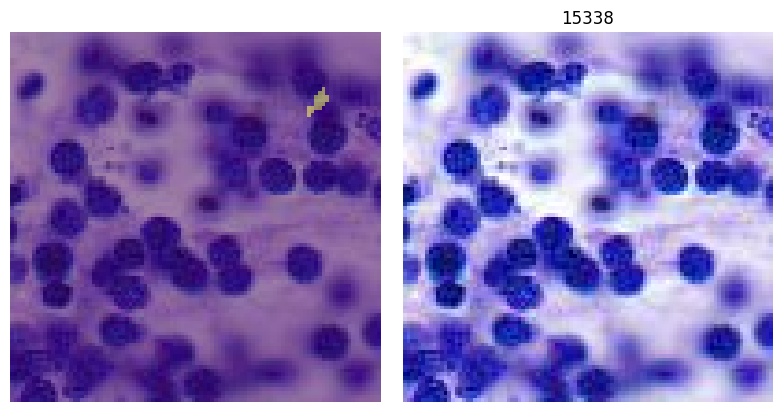

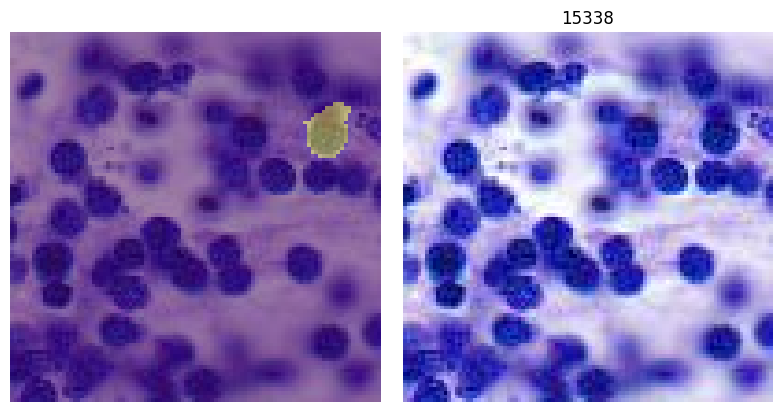

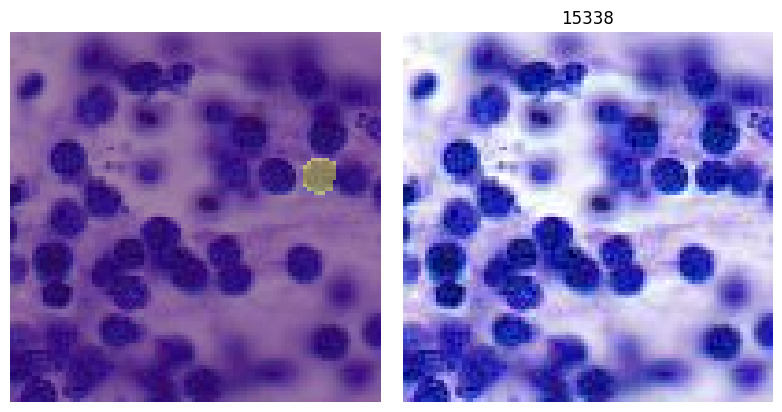

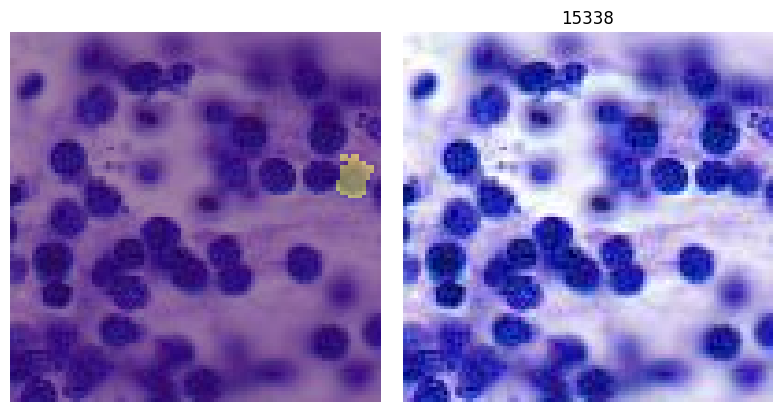

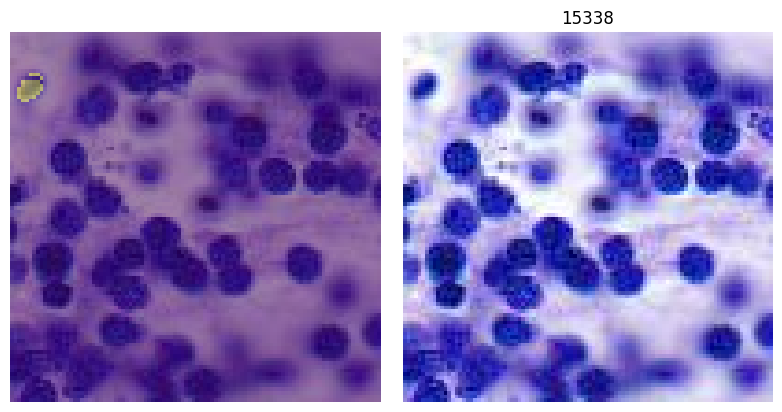

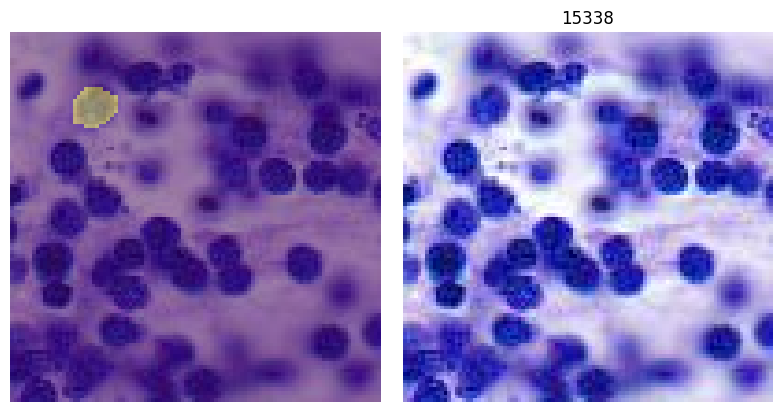

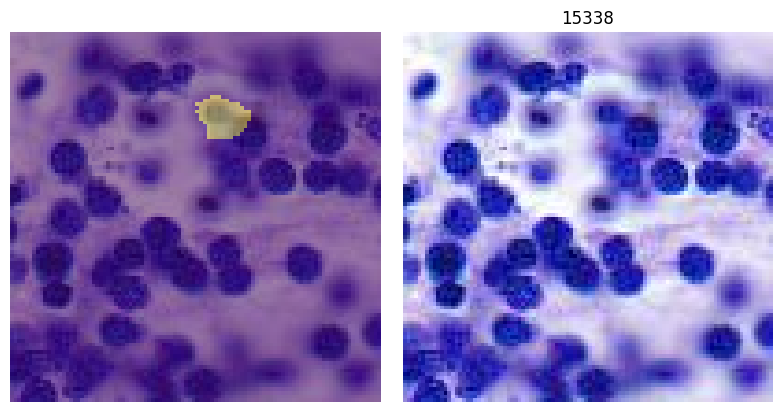

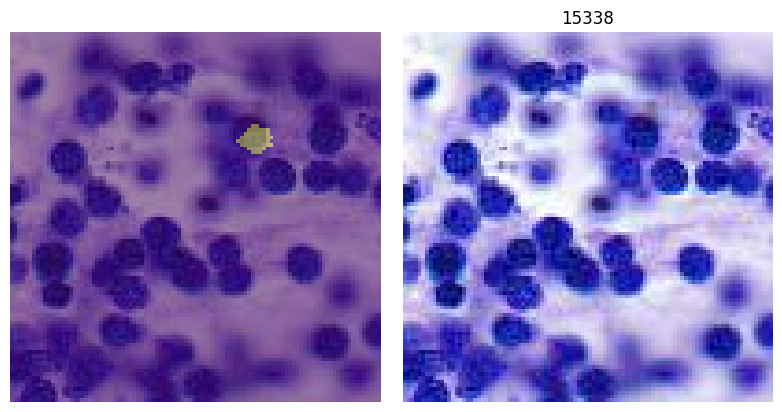

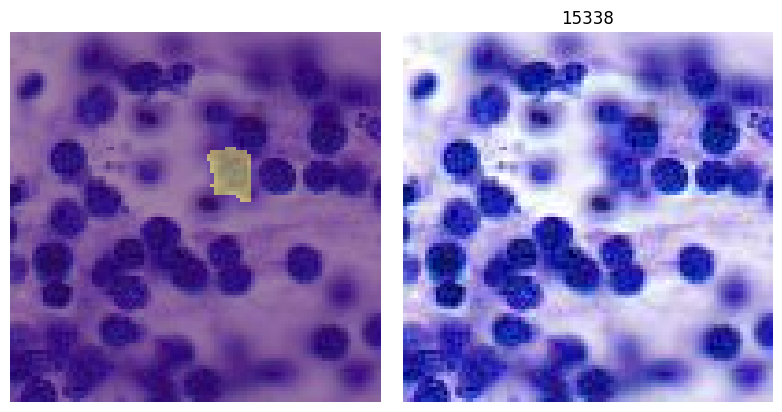

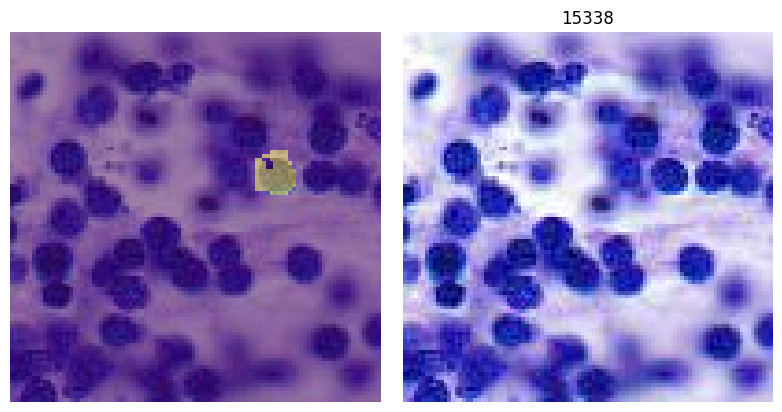

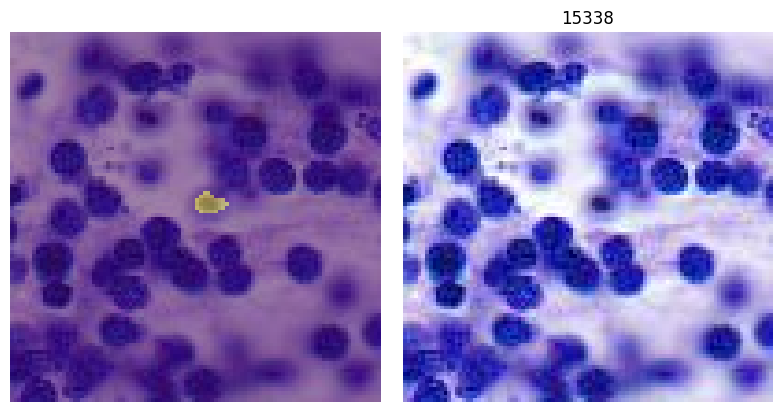

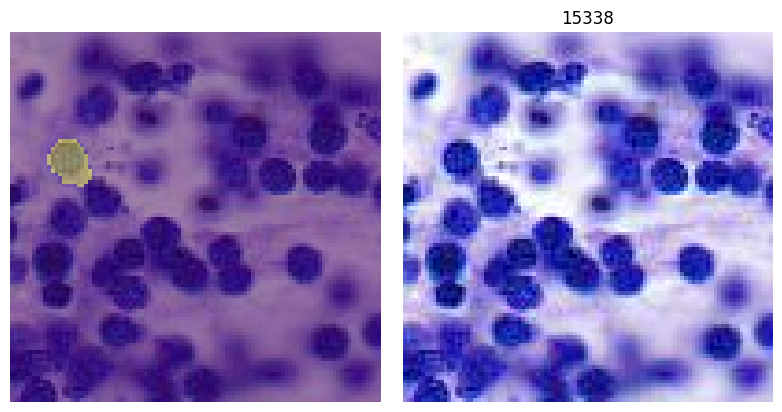

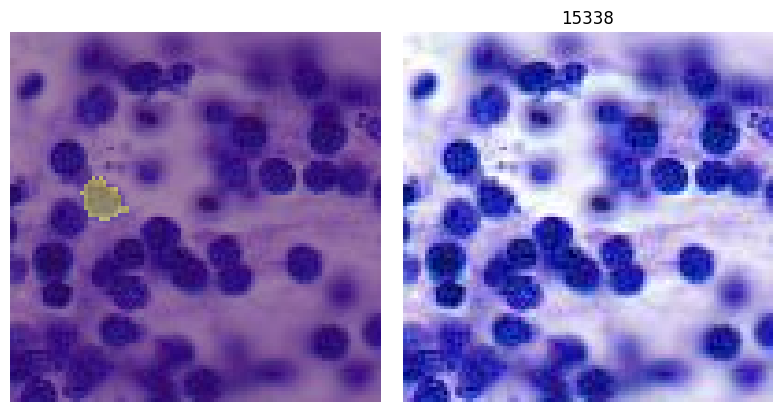

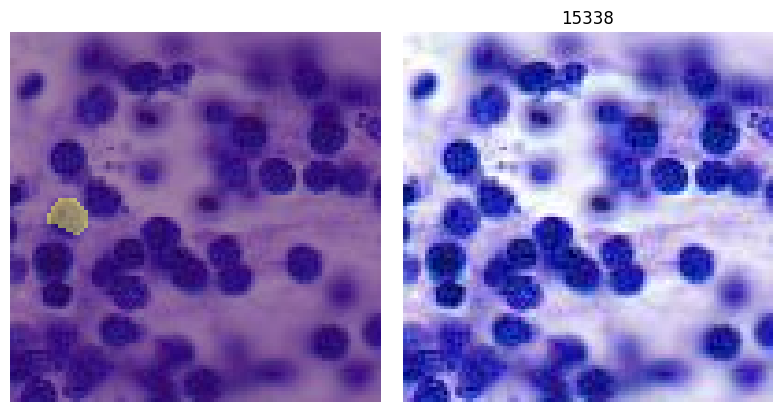

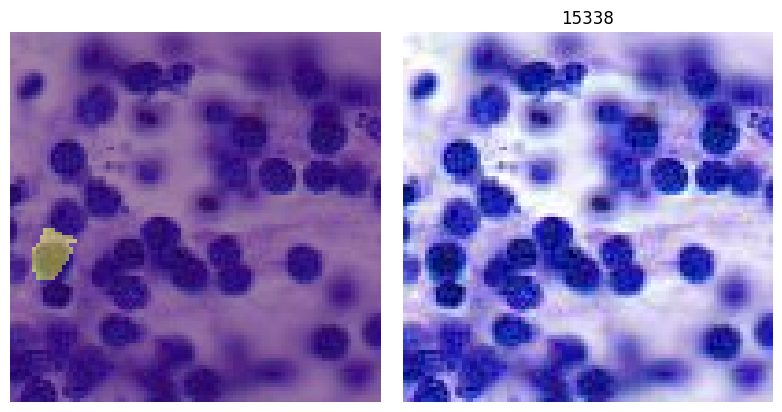

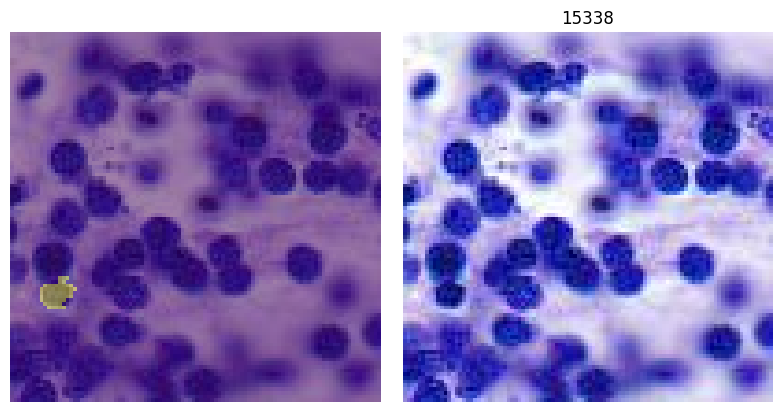

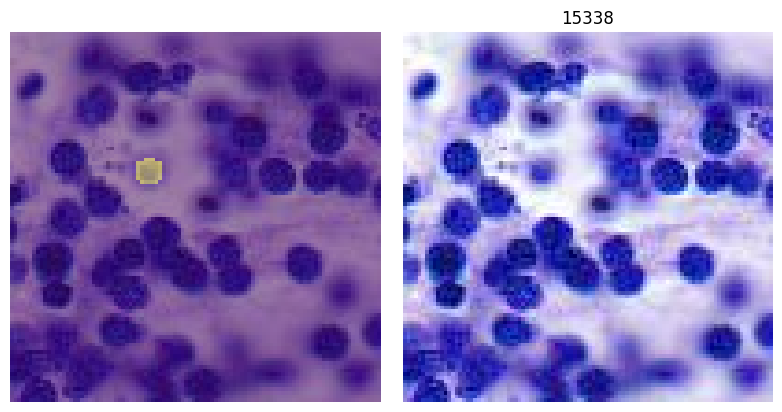

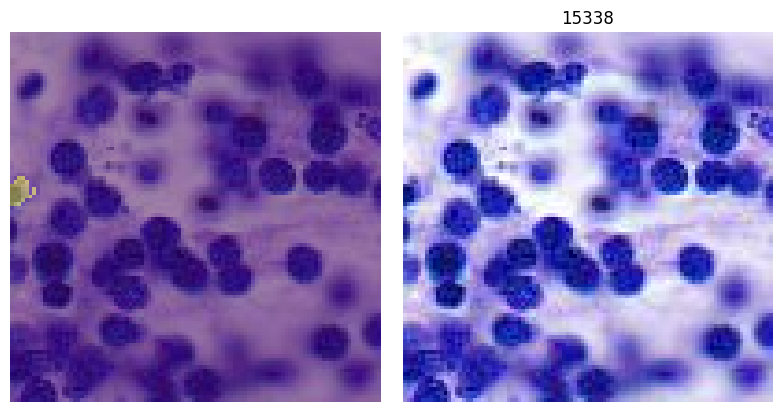

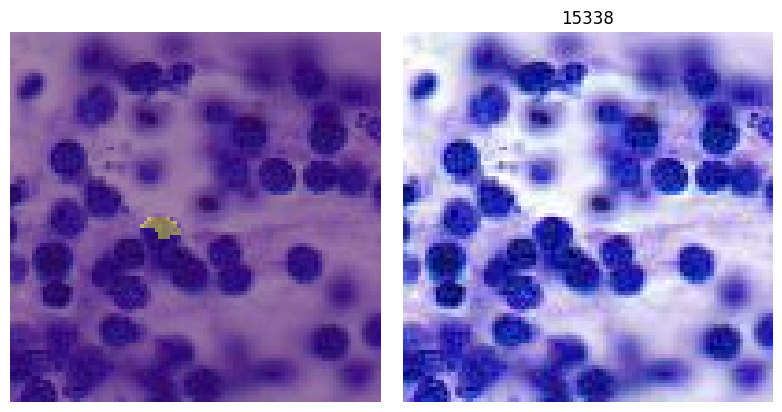

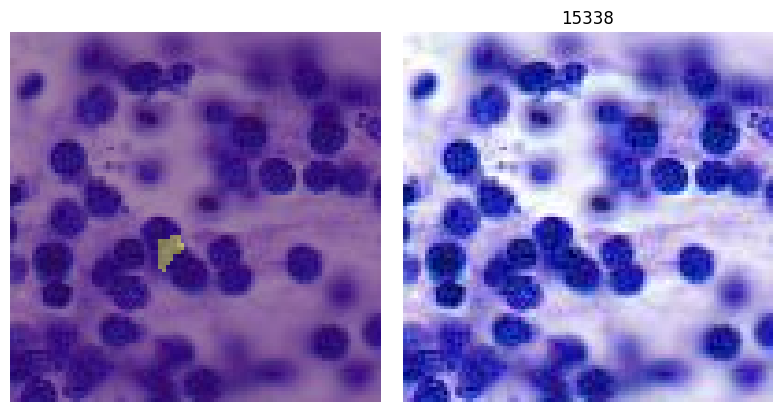

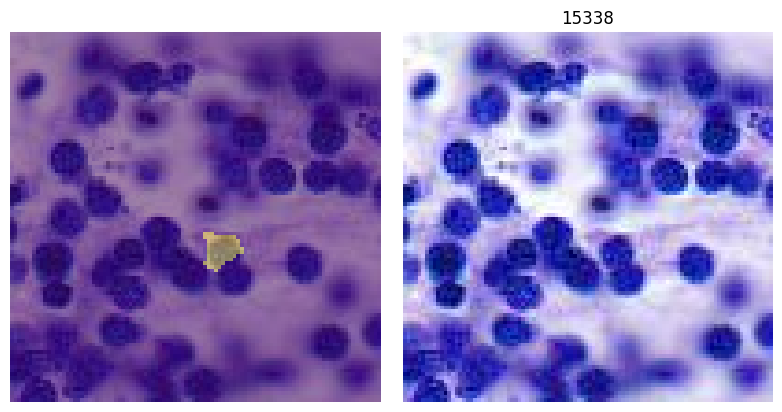

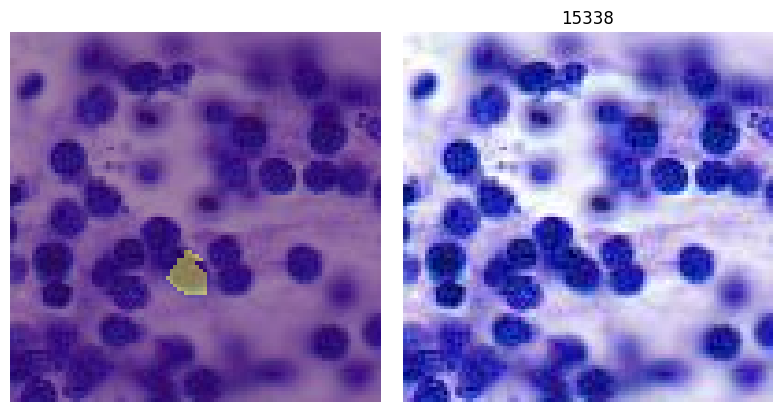

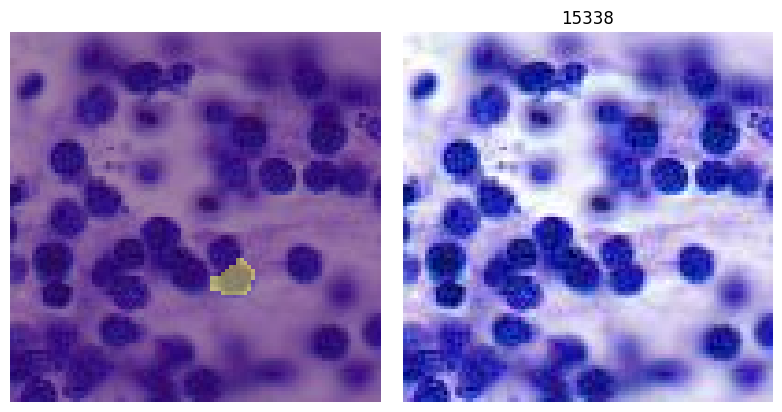

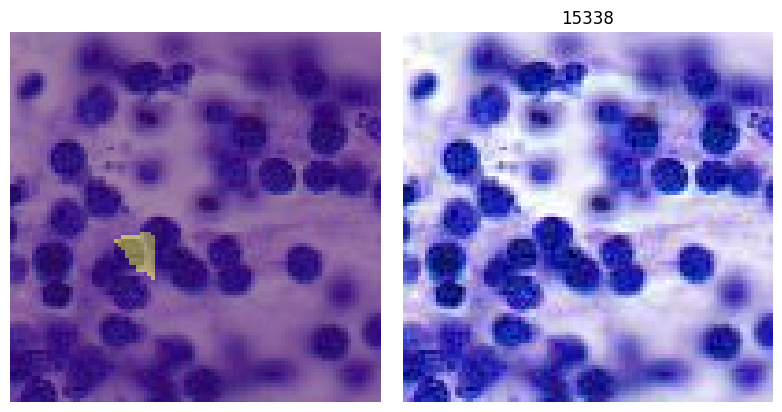

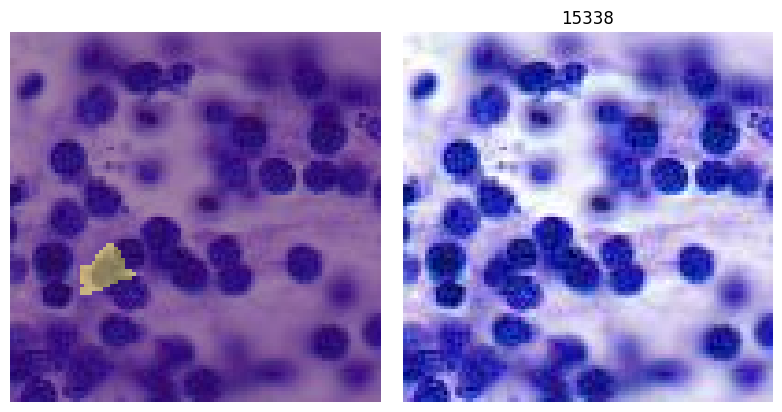

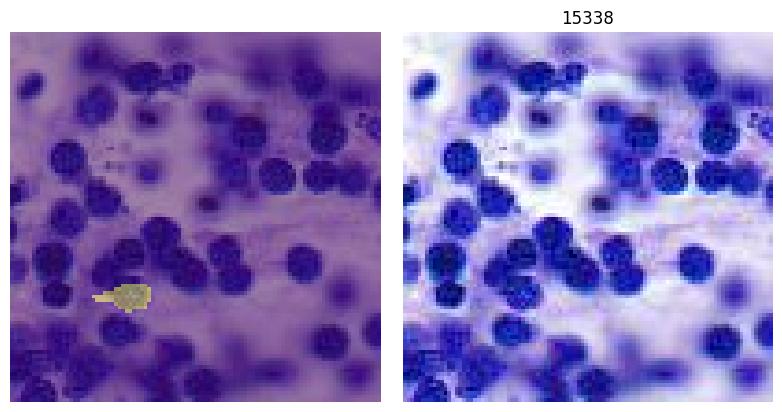

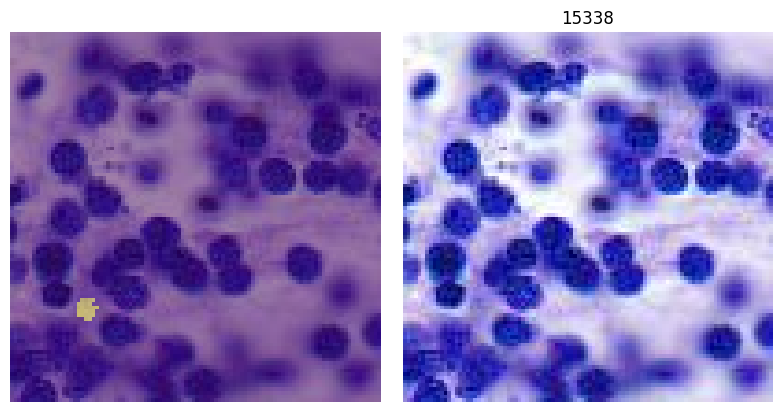

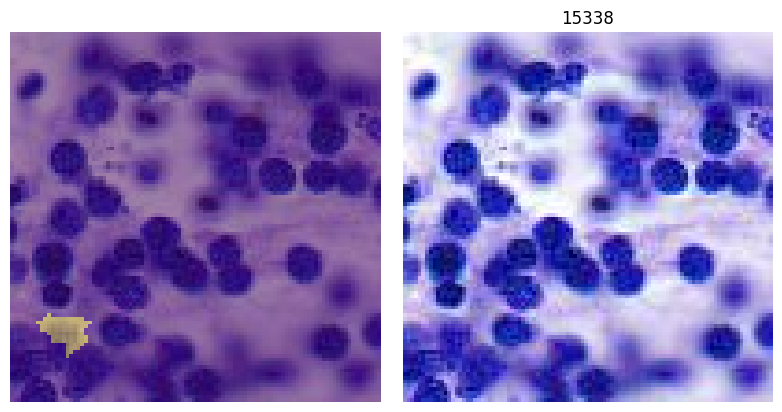

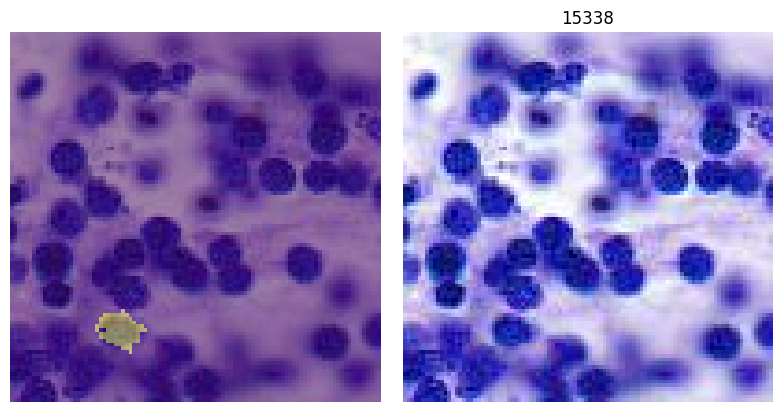

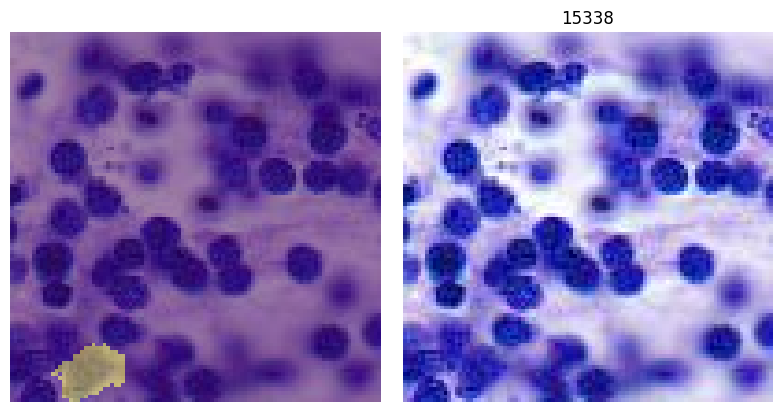

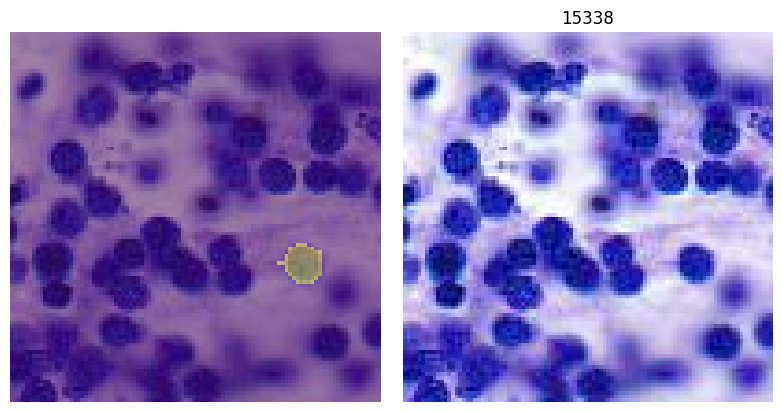

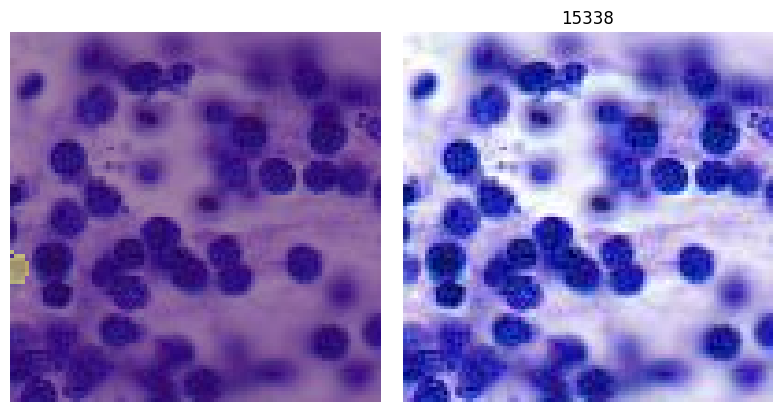

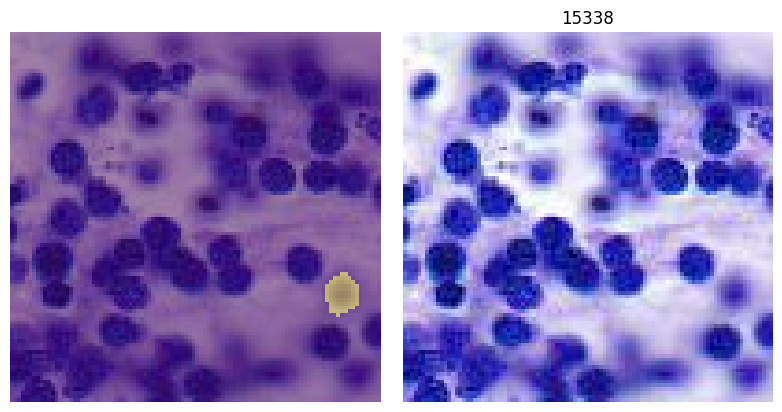

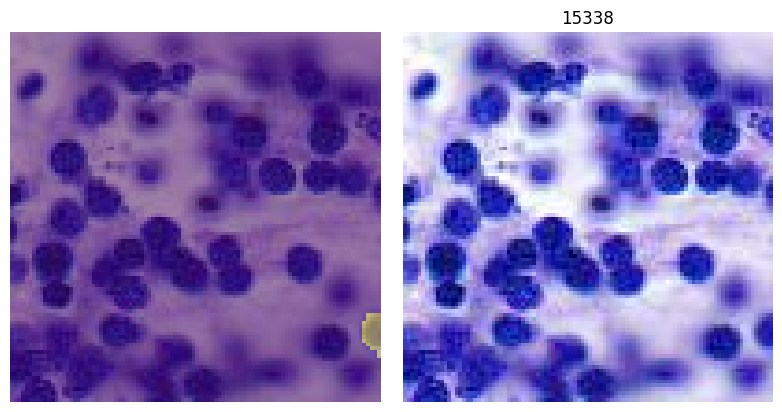

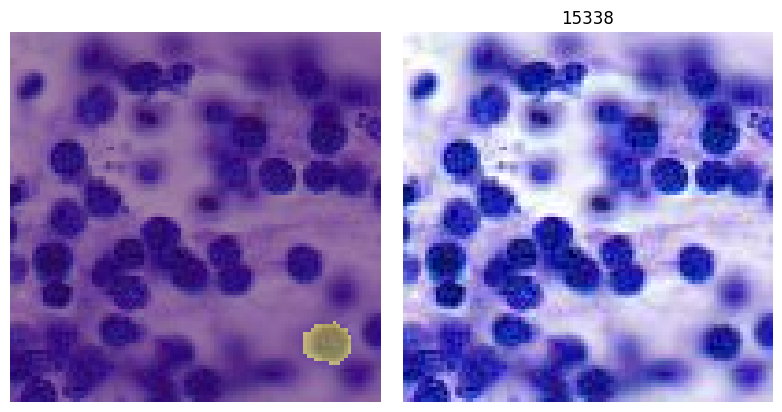

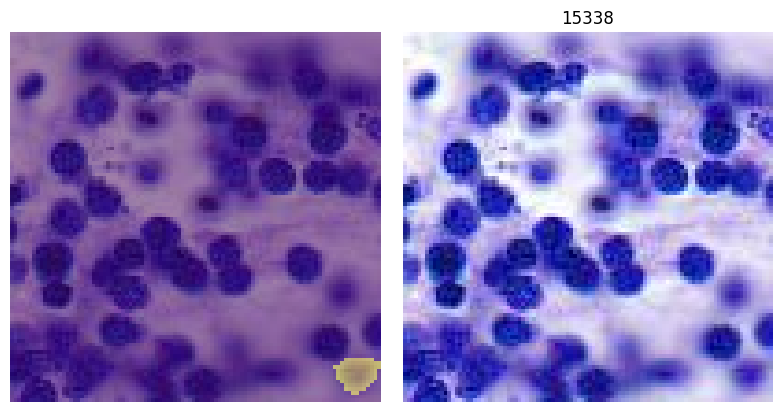

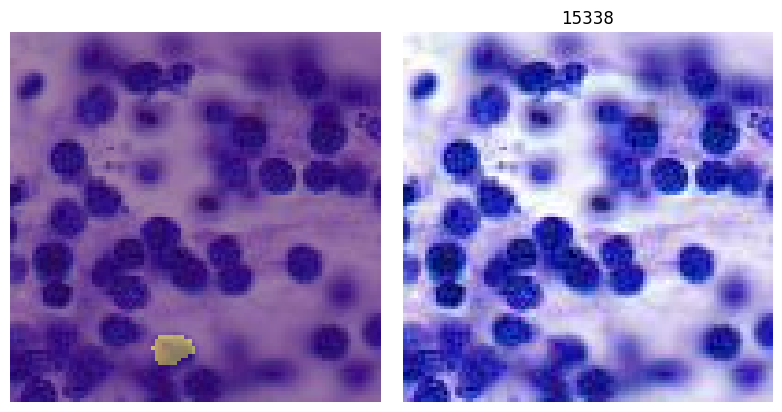

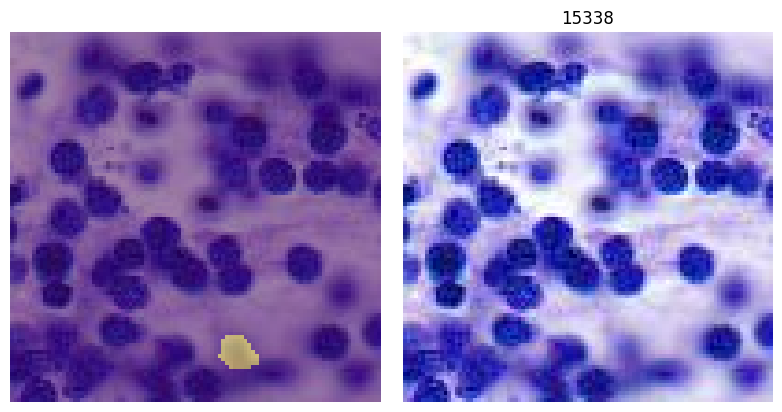

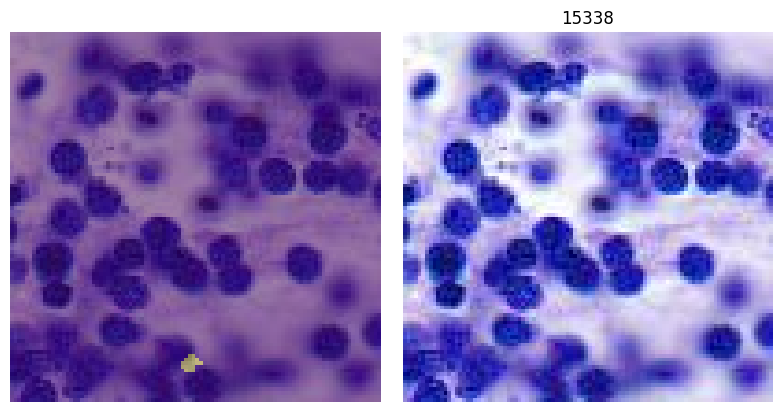

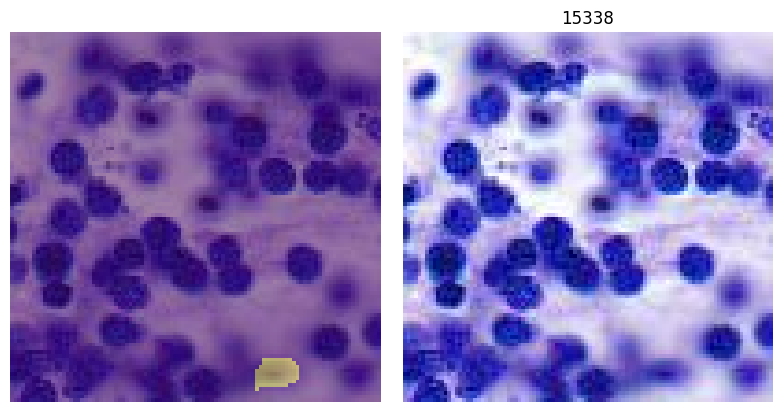

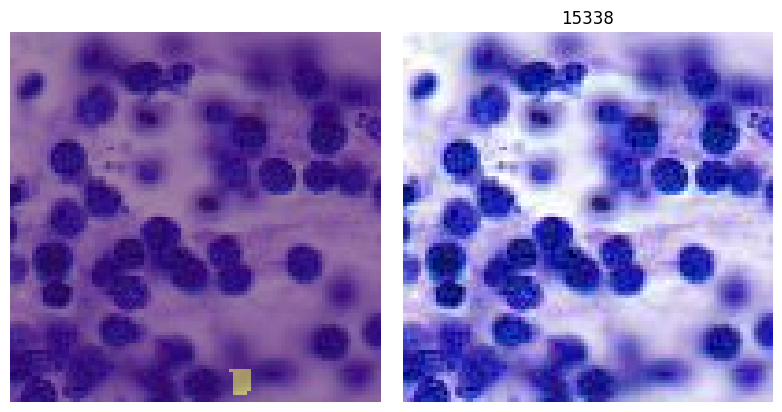

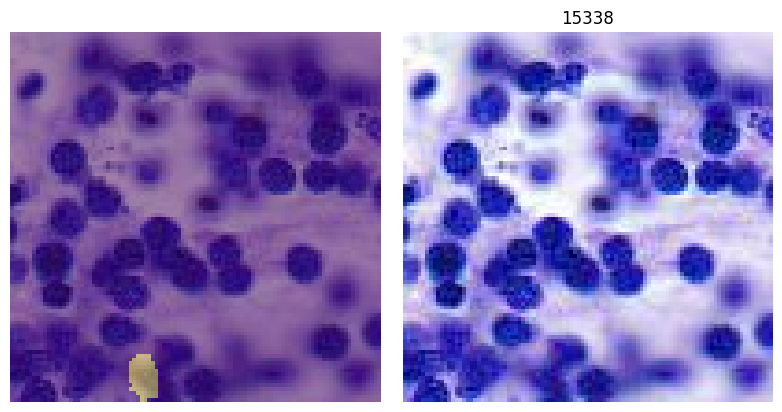

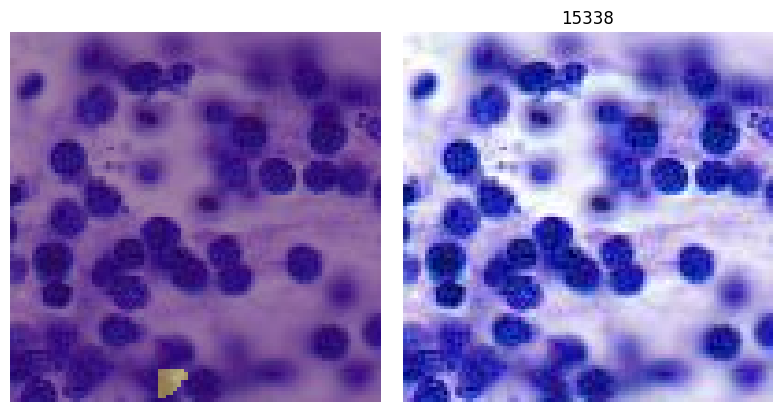

In [ ]:
for i in range(mask.shape[2]):
    show_images_side_by_side('15338',mask[:,:,i],orig_img[300:400,300:400,:],orig_img[300:400,300:400,:])
    plt.show()